In [1]:
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import networkx as nx

%matplotlib inline

In [2]:
# Load data
result_dir = Path('result_files')

lowly_cited_time_span = np.load(result_dir / 'lowly_cited_time_span.npy')
highly_cited_time_span = np.load(result_dir / 'highly_cited_time_span.npy')
time_span_most_cited_paper = np.load(result_dir / 'time_span_most_cited_paper.npy')

In [3]:
plot_dir = Path("figures")

plot_dir.mkdir(exist_ok=True)

### Plot figures

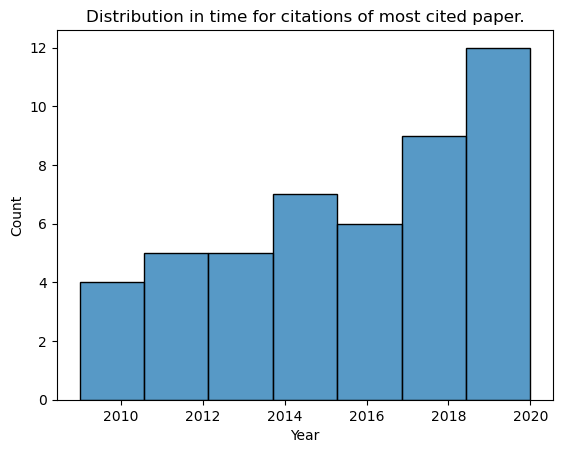

In [4]:
sns.histplot(time_span_most_cited_paper)
plt.xlabel('Year')
plt.title('Distribution in time for citations of most cited paper.')

plt.savefig(plot_dir / "time_span_most_cited_paper.png")
plt.show()

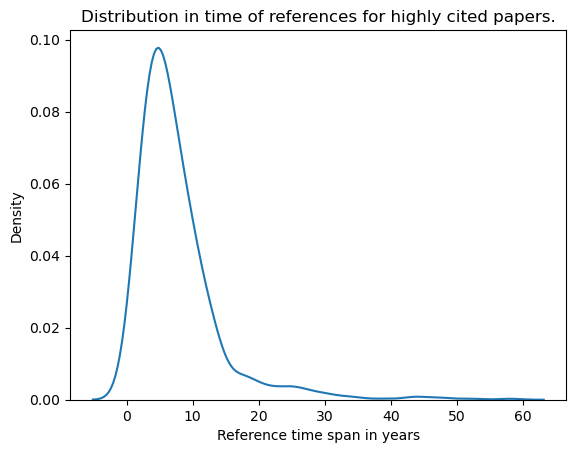

In [4]:
sns.kdeplot(highly_cited_time_span)
plt.xlabel('Reference time span in years')
plt.title("Distribution in time of references for highly cited papers.")
# plt.savefig(plot_dir / "time_span_highly_cited_paper.png")
plt.show()

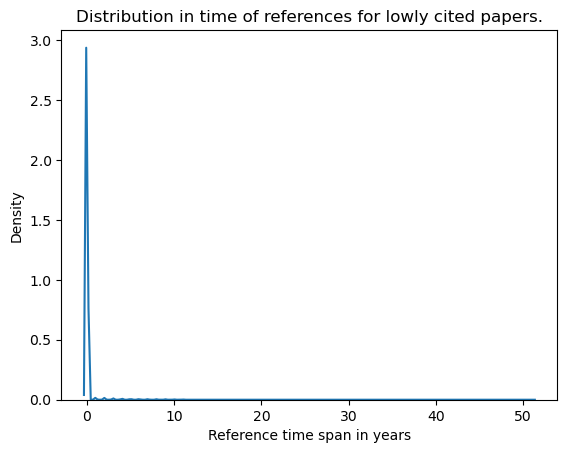

In [5]:
sns.kdeplot(lowly_cited_time_span)
plt.xlabel('Reference time span in years')
plt.title("Distribution in time of references for lowly cited papers.")
# plt.savefig(plot_dir / "time_span_lowly_cited_paper.png")
plt.show()

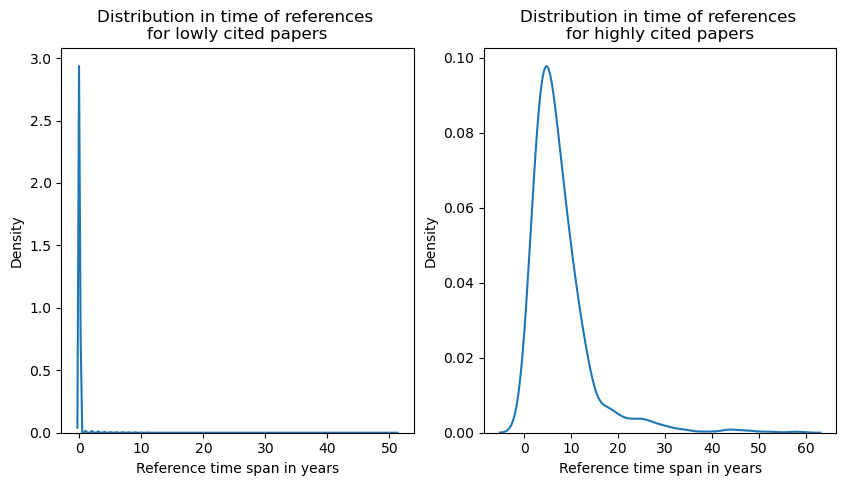

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.kdeplot(highly_cited_time_span, ax=axs[1])
axs[1].set_xlabel('Reference time span in years')
axs[1].set_title("Distribution in time of references \nfor highly cited papers")

sns.kdeplot(lowly_cited_time_span, ax=axs[0])
axs[0].set_xlabel('Reference time span in years')
axs[0].set_title("Distribution in time of references \nfor lowly cited papers")

plt.savefig(plot_dir / "time_span_citations.png")
plt.show()

### Graphs

In [7]:
# Load data:
import pickle
# small_graph_file = "/commons/dsls/dsph/2022/graph_data/small_adjlist_subset_data_3.csv"
small_graph_file = "/commons/dsls/dsph/2022/graph_data/small_adjlist_subset_data_4.csv"

attributes_3_file = "/commons/dsls/dsph/2022/graph_data/attributes_subgraph_3.pkl"

with open(attributes_3_file, 'rb') as fh:
    attributes_3 = pickle.load(fh)

len(attributes_3)

small_graph = nx.read_adjlist(small_graph_file, create_using=nx.DiGraph)
nx.set_node_attributes(small_graph, attributes_3)

In [8]:
#  attributes_3['31210720']

In [9]:
len(list(small_graph.nodes()))

1165

In [10]:
len(nx.get_node_attributes(small_graph, 'author'))

1165

### Draw a graph that depicts if articles have key words in common

In [11]:
edge_widths, edge_colors = [], []
edge_alphas = []
for node1, node2 in list(small_graph.edges):
    attr_node1 = small_graph.nodes[node1]['key_words']
    attr_node2 = small_graph.nodes[node2]['key_words']
    edge_width, edge_color = 0.5, 'black'
    alpha = 0.3
    if attr_node1 and attr_node2:
        intersect = set(attr_node1) & set(attr_node2)
        if intersect:
            edge_width = 1.2
            edge_color = 'red'
            alpha = 0.8

    edge_widths.append(edge_width)
    edge_colors.append(edge_color)
    edge_alphas.append(alpha)


/commons/conda/dsls/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


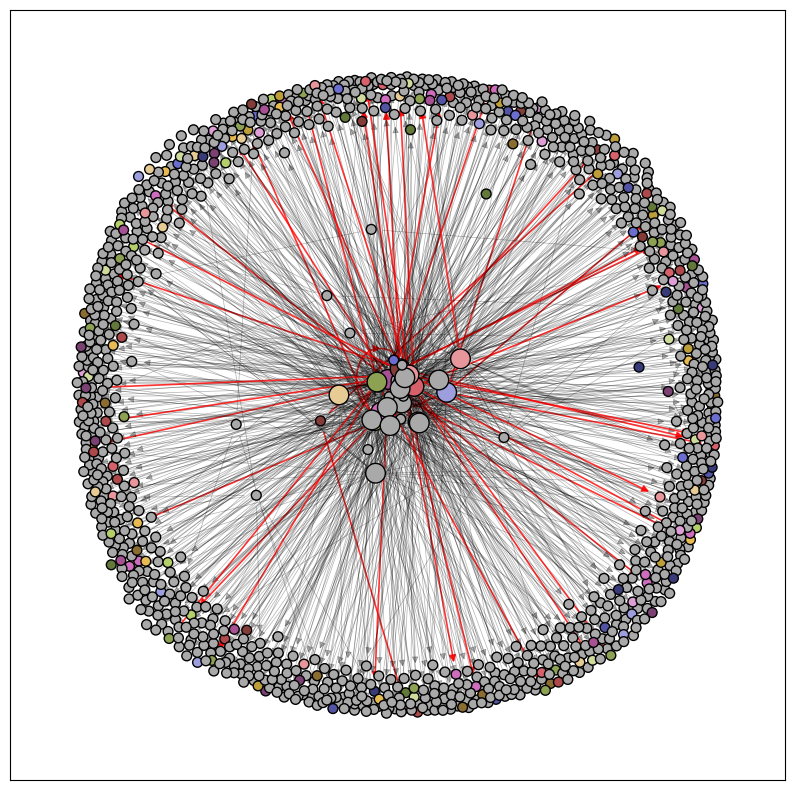

In [12]:
fig = plt.figure(figsize=(10, 10))

pos = nx.spring_layout(small_graph)

labels = {}

node_sizes = []

for node, out_degr in list(small_graph.out_degree):
        if out_degr > 20:
            labels[node] = node
            node_sizes.append(200)
        else:
            labels[node] = ""
            node_sizes.append(50)


key_words_data = {node:(key_words[0] if key_words else "None") for node, key_words in nx.get_node_attributes(small_graph,'key_words').items()}

groups = set(key_words_data.values())
mapping = {}
set_1 = cm.get_cmap('tab20b', len(groups))

for group, color in zip(groups, set_1.colors):
    mapping[group] = color
    if group == 'None':
        mapping[group] = 'darkgray'


nodes = small_graph.nodes()
colors = [mapping[small_graph.nodes[n]['key_words'][0]] if small_graph.nodes[n]['key_words'] else mapping['None'] for n in nodes]


ec = nx.draw_networkx_edges(small_graph, pos, alpha=edge_alphas, edge_color=edge_colors, width=edge_widths)
nc = nx.draw_networkx_nodes(small_graph, pos, nodelist=nodes, 
        node_color=colors, node_size=node_sizes, linewidths=1.0, edgecolors='black')# cmap=plt.cm.jet

plt.savefig(plot_dir / "key_words_graph.png")
plt.show()

### Draw a graph that depicts if nodes have authors in common

In [13]:
author_co_authors_flat = {}

for pmid, author in nx.get_node_attributes(small_graph, 'author').items():
    co_authors = small_graph.nodes[pmid]['co_authors']
    if author not in author_co_authors_flat:
        author_co_authors_flat[author] = co_authors
        author_co_authors_flat[author].insert(0, author)
    else:
        author_co_authors_flat[author].extend(co_authors)


In [14]:
check_c = 0
edge_widths, edge_colors = [], []
edge_alphas = []
node_colors = {}
for node1, node2 in list(small_graph.edges):
    author_node1 = small_graph.nodes[node1]['author']
    co_authors_node1 = small_graph.nodes[node1]['co_authors']

    author_node2 = small_graph.nodes[node2]['author']
    co_authors_node2 = small_graph.nodes[node2]['co_authors']
    all_authors = [author_node2] + co_authors_node2
    edge_width, edge_color = 0.5, 'black'
    alpha, node_color = 0.3, 'lightsteelblue'
    if all_authors:
        intersect = set(author_co_authors_flat[author_node1]) & set(all_authors)
        if intersect:
            check_c += 1
            edge_width = 1.2
            edge_color = 'tomato'
            alpha = 0.8
            node_color = 'red'
            # Force the color
            node_colors[node1] = node_color
            node_colors[node2] = node_color

    edge_widths.append(edge_width)
    edge_colors.append(edge_color)
    edge_alphas.append(alpha)
    if node1 not in node_colors:
        node_colors[node1] = node_color

    if node2 not in node_colors:
        node_colors[node2] = node_color


In [15]:
check_c

193

In [16]:
# Make sure that the node colors are in the correct order
index_map = {v: i for i, v in enumerate(nodes)}
node_colors_sorted = sorted(node_colors.items(), key=lambda pair: index_map[pair[0]])
node_colors_sorted = list(map(lambda x: x[1], node_colors_sorted))

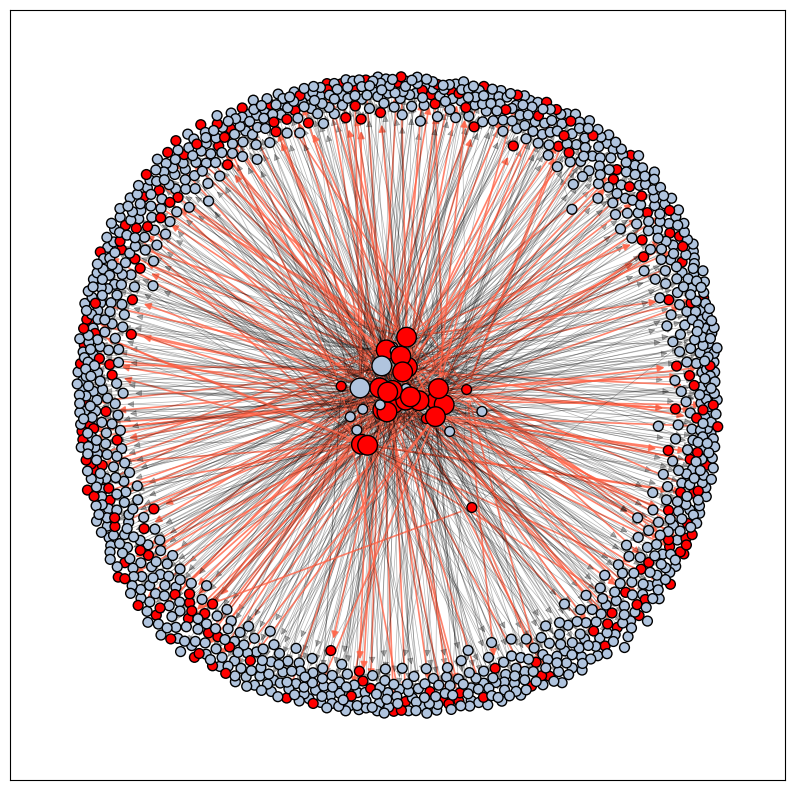

In [17]:
fig = plt.figure(figsize=(10, 10))

pos = nx.spring_layout(small_graph)

labels = {}

node_sizes = []

for node, out_degr in list(small_graph.out_degree):
        if out_degr > 20:
            labels[node] = node
            node_sizes.append(200)
        else:
            labels[node] = ""
            node_sizes.append(50)

nodes = small_graph.nodes()

ec = nx.draw_networkx_edges(small_graph, pos, alpha=edge_alphas, edge_color=edge_colors, width=edge_widths)
nc = nx.draw_networkx_nodes(small_graph, pos, nodelist=nodes,node_size=node_sizes, edgecolors='black',
            node_color=node_colors_sorted)# cmap=plt.cm.jet

plt.savefig(plot_dir / 'common_authors_graph.png')
plt.show()

#### Graph to check for papers citing different languages

In [18]:
edge_widths, edge_colors = [], []
edge_alphas = []
for node1, node2 in list(small_graph.edges):
    attr_node1 = small_graph.nodes[node1]['language']
    attr_node2 = small_graph.nodes[node2]['language']
    edge_width, edge_color = 0.5, 'black'
    alpha = 0.3
    if attr_node1 and attr_node2:
        if attr_node1 != attr_node2:
            edge_width = 1.2
            edge_color = 'red'
            alpha = 0.8

    edge_widths.append(edge_width)
    edge_colors.append(edge_color)
    edge_alphas.append(alpha)


In [19]:
all_languages = list(nx.get_node_attributes(small_graph, 'language').values())
unique_languages = np.unique(all_languages)
unique_languages

array(['chi', 'cze', 'eng', 'ger', 'jpn', 'und'], dtype='<U3')

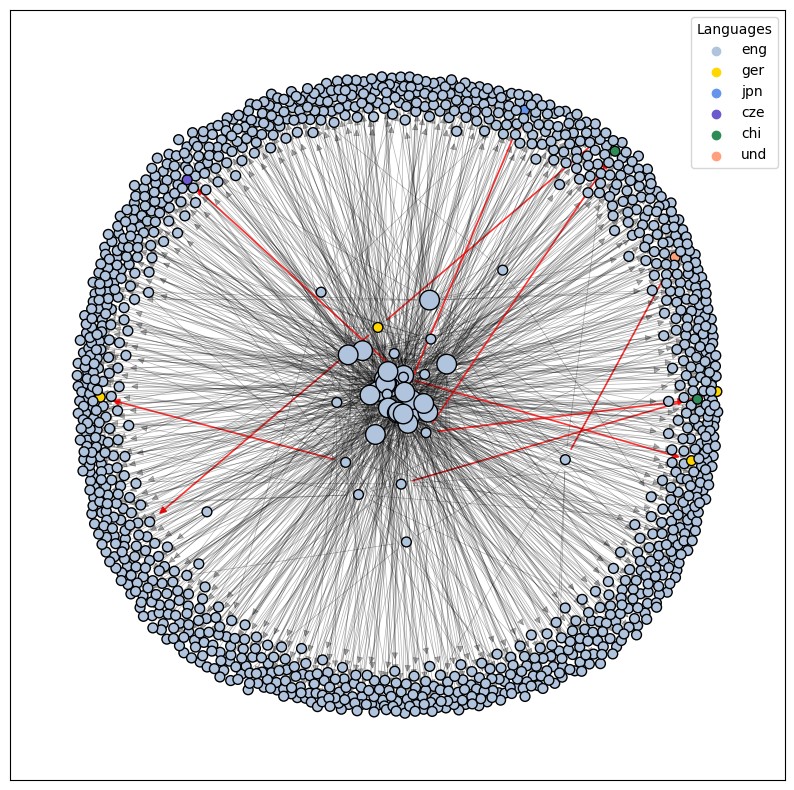

In [20]:
fig = plt.figure(figsize=(10, 10))

pos = nx.spring_layout(small_graph)

labels = {}

node_sizes = []

for node, out_degr in list(small_graph.out_degree):
        if out_degr > 20:
            labels[node] = node
            node_sizes.append(200)
        else:
            labels[node] = ""
            node_sizes.append(50)

color_map = {'eng': 'lightsteelblue', 'ger': 'gold',
             'jpn': 'cornflowerblue', 'cze': 'slateblue',
             'chi': 'seagreen', 'und': 'lightsalmon'}

nodes = small_graph.nodes()
colors = [color_map[small_graph.nodes[n]['language']] for n in nodes]


ec = nx.draw_networkx_edges(small_graph, pos, alpha=edge_alphas, edge_color=edge_colors, width=edge_widths)
nc = nx.draw_networkx_nodes(small_graph, pos, nodelist=nodes, 
        node_color=colors, node_size=node_sizes, linewidths=1.0, edgecolors='black')# cmap=plt.cm.jet


# plt.legend() # how to add legend: https://stackoverflow.com/questions/60706947/how-to-add-a-legend-to-networkx-graph-based-on-node-colour
for v, col in color_map.items():
    plt.scatter([],[], c=[col], label=f'{v}')
plt.legend(loc="upper right", title='Languages')# bbox_to_anchor=(1,1),

plt.savefig(plot_dir / 'language_graph.png')
plt.show()
